# Fruit Classifier - CNN Model

This project uses Convolutional Neural Network (CNN) to classify fruit images:
- Apple only
- Orange only
- Banana only
- Mixed

Target Accuracy: 92%

## 1. Import Required Libraries

## 0. Environment Setup

**Important**: If you encounter NumPy import errors, run this cell to fix dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display TensorFlow and GPU information
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# GPU Status
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU Status: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # Check GPU memory info (if available)
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'device_name' in gpu_details:
            print(f"  Device Name: {gpu_details['device_name']}")
    except:
        pass
else:
    print("\nGPU Status: Running on CPU")
    
print("=" * 60)

2025-12-02 00:45:56.578766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 00:45:56.613201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 00:45:57.695564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
Keras version: 3.12.0

GPU Status: 1 GPU(s) available
  GPU 0: /physical_device:GPU:0
  Device Name: NVIDIA GeForce RTX 3080


## 2. Setup Data Paths and Parameters

## 1.5. Data Synchronization

In [2]:
# Data paths
train_dir = '/home/zyh/Fruit-Classifier/data/train'
test_dir = '/home/zyh/Fruit-Classifier/data/test'

# Model parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # apple, banana, orange, mixed [modified]

# Class names [modified]
class_names = ['apple', 'banana', 'mixed', 'orange']

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of classes: {NUM_CLASSES}")

Training data path: /home/zyh/Fruit-Classifier/data/train
Testing data path: /home/zyh/Fruit-Classifier/data/test
Image size: 224x224
Batch size: 32
Epochs: 50
Number of classes: 4


## 3. Data Exploration

## 2.5. Organize Test Data (Run Once)

In [3]:
# Count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = num_images
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set image counts:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(train_counts.values())}\n")

print("Test set image counts:")
for class_name, count in sorted(test_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(test_counts.values())}")

Training set image counts:
  apple: 75
  banana: 72
  mixed: 21
  orange: 72
  Total: 240

Test set image counts:
  apple_only: 19
  banana_only: 18
  mixed_only: 5
  orange_only: 18
  Total: 60


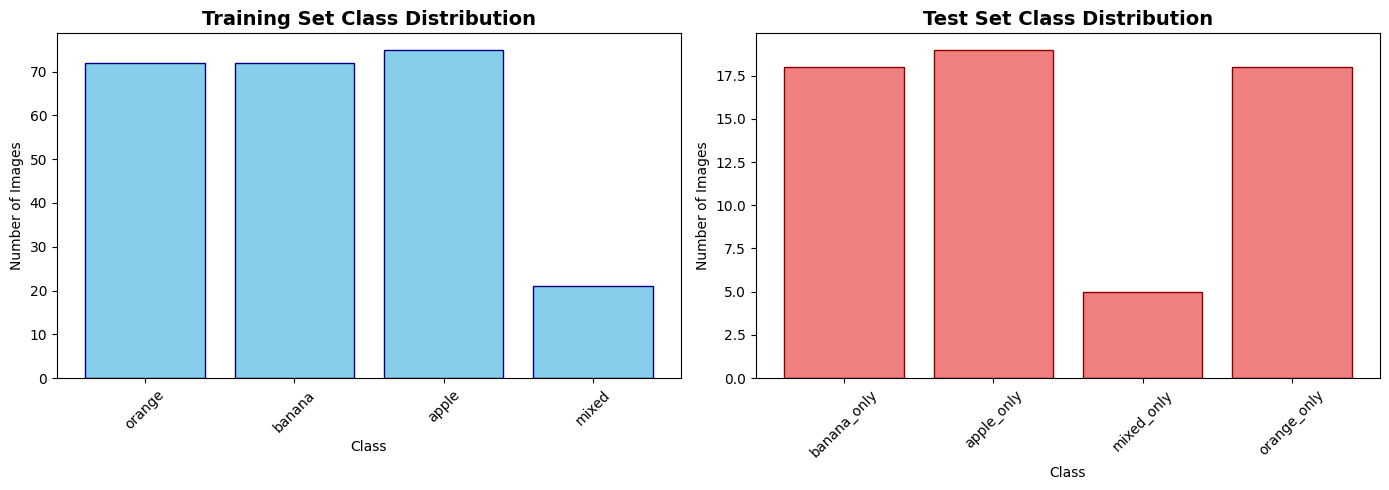

In [4]:
def plot_class_distribution(train_counts, test_counts):
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Training set distribution
    ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='navy')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)

    # Test set distribution
    ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='darkred')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


plot_class_distribution(train_counts, test_counts)

## 4. Data Preprocessing and Augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

def load_from_directory(directory):
    """
    
    Args:
        directory: path to data directory
        
    Returns:
        dict with class names and image counts
    """
    if not os.path.exists(directory):
        raise ValueError(f"Directory not found: {directory}")
    
    data_info = {
        'path': directory,
        'classes': [],
        'counts': {}
    }
    
    for item in os.listdir(directory):
        class_path = os.path.join(directory, item)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if images:
                data_info['classes'].append(item)
                data_info['counts'][item] = len(images)
    
    data_info['total'] = sum(data_info['counts'].values())
    data_info['num_classes'] = len(data_info['classes'])
    
    return data_info


def get_preprocessor(method='baseline', img_size=224, batch_size=32, train_dir=train_dir, test_dir=test_dir, val_split=0.2):
    """
    Get data generators with different preprocessing methods
    
    Args:
        method: 'baseline', 'light', 'heavy', 'moderate', 'minimal'
        img_size: image dimension (default 224)
        batch_size: batch size for training (default 32)
        train_dir: training data directory
        test_dir: test data directory
        val_split: validation split ratio (default 0.2)
    
    Returns:
        train_gen, val_gen, test_gen
    """
    
    if method == 'baseline':
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)
        
    elif method == 'light':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            horizontal_flip=True,
            validation_split=val_split
        )
        
    elif method == 'heavy':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=val_split
        )
        
    elif method == 'moderate':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=val_split
        )
        
    elif method == 'minimal':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            zoom_range=0.1,
            validation_split=val_split
        )
        
    else:
        raise ValueError(f"Unknown method: {method}. Choose from: baseline, light, heavy, moderate, minimal")
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    val_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen


def list_methods():
    methods = {
        'baseline': 'No augmentation, only rescaling',
        'light': 'Rotation (15°) + Horizontal flip',
        'heavy': 'Full augmentation (rotation, shift, zoom, shear, brightness, flips)',
        'moderate': 'Balanced augmentation (rotation, shift, zoom, flip)',
        'minimal': 'Minimal augmentation (slight rotation, zoom)'
    }
    print("Available preprocessing methods:")
    for key, desc in methods.items():
        print(f"  - {key:12s}: {desc}")
    return methods


In [6]:
train_generator,validation_generator,test_generator = get_preprocessor(method='moderate', img_size=224, batch_size=32, train_dir=train_dir, test_dir=test_dir, val_split=0.2)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")


Found 193 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 60 images belonging to 4 classes.

Training samples: 193
Validation samples: 47
Test samples: 60

Class indices: {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}


### Added code block to calculate weights [YC]

In [7]:
from sklearn.utils import class_weight
import numpy as np

# Calculate weights based on the training generator's data
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to a dictionary format that Keras expects
class_weights = dict(enumerate(weights))

print("Class Indices:", train_generator.class_indices)
print("Calculated Weights:", class_weights)

Class Indices: {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}
Calculated Weights: {0: np.float64(0.8041666666666667), 1: np.float64(0.8318965517241379), 2: np.float64(2.838235294117647), 3: np.float64(0.8318965517241379)}


## 5. Build Basic CNN Model

In [8]:
def create_cnn_model():

    model = models.Sequential()

    #Convolution blocks
    model.add(layers.Conv2D(32, kernel_size = (3,3), 
                    padding='same',
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(64, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(128, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    #Classification layers
    model.add(layers.Flatten())

    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32,activation='relu'))

    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(NUM_CLASSES,activation='softmax'))

    model.summary()

    return model

# Create model
model = create_cnn_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

I0000 00:00:1764607829.470011 2694127 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,052 (24.86 MB)

 Trainable params: 6,518,052 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,052 (24.86 MB)

 Trainable params: 6,518,052 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Setup Training Callbacks

In [9]:
# Setup callbacks
callbacks = [
    # Early stopping: stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint: save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Learning rate reduction: reduce LR if validation loss stops improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")

Callbacks configured


## 7. Train Model

In [10]:
import time
start_time = time.time()
# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds!")

Epoch 1/50


2025-12-02 00:53:08.661149: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f0278003430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 00:53:08.661178: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-02 00:53:08.714399: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 00:53:09.034208: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-02 00:53:09.229301: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 00:53:09.977196: I e

1/7 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.3125 - loss: 1.6466

I0000 00:00:1764607993.450188 2695300 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/7 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.2112 - loss: 2.1648
Epoch 1: val_accuracy improved from None to 0.63830, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 948ms/step - accuracy: 0.2228 - loss: 1.8674 - val_accuracy: 0.6383 - val_loss: 1.3326 - learning_rate: 5.0000e-04
Epoch 2/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.3006 - loss: 1.4203
Epoch 2: val_accuracy did not improve from 0.63830
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.3057 - loss: 1.3950 - val_accuracy: 0.3191 - val_loss: 1.2649 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.2633 - loss: 1.3874
Epoch 3: val_accuracy did not improve from 0.63830
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.3938 - loss: 1.3344 - val_accuracy: 0.4255 - val_loss: 1.2156 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4163 - loss: 1.2204
Epoch 4: val_accuracy did not improve from 0.63830
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.4560 - loss: 1.2367 - val_accuracy: 0.6170 - val_loss: 1.0771 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.6010 - loss: 1.1638 - val_accuracy: 0.7021 - val_loss: 0.9220 - learning_rate: 5.0000e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5809 - loss: 1.0798
Epoch 11: val_accuracy did not improve from 0.70213
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.6062 - loss: 1.0323 - val_accuracy: 0.6170 - val_loss: 0.9710 - learning_rate: 5.0000e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.5398 - loss: 1.0398
Epoch 12: val_accuracy did not improve from 0.70213

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.5078 - loss: 1.1016 - val_accuracy: 0.5957 - val_loss: 1.0822 - learning_rate: 5.0000e-04
Epoch 13/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5385 - loss: 1.0696
Epoch 13: val_accuracy did not improve from 0.70213
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.5492 - loss: 1.0598 - val_acc

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.6425 - loss: 0.9897 - val_accuracy: 0.8085 - val_loss: 0.8635 - learning_rate: 2.5000e-04
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6386 - loss: 0.9289
Epoch 16: val_accuracy did not improve from 0.80851
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 518ms/step - accuracy: 0.6321 - loss: 0.9481 - val_accuracy: 0.7447 - val_loss: 0.7670 - learning_rate: 2.5000e-04
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6777 - loss: 0.9243
Epoch 17: val_accuracy did not improve from 0.80851
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.6788 - loss: 0.9077 - val_accuracy: 0.7447 - val_loss: 0.7030 - learning_rate: 2.5000e-04
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.6077 - loss: 1.0674
Epoch 18: val_accuracy did not improve from 0.80851
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.6580 - loss: 0.9412 - val_accuracy: 0.7660 - val_loss: 0.7640 - learning_rate: 2.5000e-04
Epoch 19/50
7/7 ━

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.6528 - loss: 0.9094 - val_accuracy: 0.8511 - val_loss: 0.6571 - learning_rate: 2.5000e-04
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6684 - loss: 0.8223
Epoch 20: val_accuracy did not improve from 0.85106
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.6891 - loss: 0.8306 - val_accuracy: 0.8298 - val_loss: 0.5931 - learning_rate: 2.5000e-04
Epoch 21/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7531 - loss: 0.8286
Epoch 21: val_accuracy did not improve from 0.85106
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.7409 - loss: 0.8439 - val_accuracy: 0.7660 - val_loss: 0.5785 - learning_rate: 2.5000e-04
Epoch 22/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8053 - loss: 0.6733
Epoch 22: val_accuracy did not improve from 0.85106
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.7720 - loss: 0.7219 - val_accuracy: 0.8298 - val_loss: 0.5969 - learning_rate: 2.5000e-04
Epoch 23/50
7/7 ━

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.7047 - loss: 0.8071 - val_accuracy: 0.8723 - val_loss: 0.5257 - learning_rate: 2.5000e-04
Epoch 26/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7568 - loss: 0.7672
Epoch 26: val_accuracy did not improve from 0.87234
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 0.7720 - loss: 0.6970 - val_accuracy: 0.7660 - val_loss: 0.5502 - learning_rate: 2.5000e-04
Epoch 27/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7363 - loss: 0.8097
Epoch 27: val_accuracy improved from 0.87234 to 0.89362, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.7306 - loss: 0.8092 - val_accuracy: 0.8936 - val_loss: 0.5032 - learning_rate: 2.5000e-04
Epoch 28/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7656 - loss: 0.7436
Epoch 28: val_accuracy did not improve from 0.89362
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.7668 - loss: 0.7766 - val_accuracy: 0.8085 - val_loss: 0.4654 - learning_rate: 2.5000e-04
Epoch 29/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7886 - loss: 0.6091
Epoch 29: val_accuracy did not improve from 0.89362
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.7668 - loss: 0.6317 - val_accuracy: 0.8723 - val_loss: 0.4774 - learning_rate: 2.5000e-04
Epoch 30/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7503 - loss: 0.6216
Epoch 30: val_accuracy did not improve from 0.89362
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.7720 - loss: 0.6646 - val_accuracy: 0.8511 - val_loss: 0.4313 - learning_rate: 2.5000e-04
Epoch 31/50
7/7 ━

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.7617 - loss: 0.7515 - val_accuracy: 0.9362 - val_loss: 0.3794 - learning_rate: 2.5000e-04
Epoch 33/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8166 - loss: 0.5532
Epoch 33: val_accuracy did not improve from 0.93617
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.7979 - loss: 0.6009 - val_accuracy: 0.8511 - val_loss: 0.4319 - learning_rate: 2.5000e-04
Epoch 34/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8802 - loss: 0.4906
Epoch 34: val_accuracy did not improve from 0.93617
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 0.8601 - loss: 0.5253 - val_accuracy: 0.8723 - val_loss: 0.3775 - learning_rate: 2.5000e-04
Epoch 35/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8971 - loss: 0.5361
Epoch 35: val_accuracy improved from 0.93617 to 0.95745, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.8446 - loss: 0.6880 - val_accuracy: 0.9574 - val_loss: 0.3208 - learning_rate: 2.5000e-04
Epoch 36/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7595 - loss: 0.6258
Epoch 36: val_accuracy did not improve from 0.95745
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step - accuracy: 0.7565 - loss: 0.7256 - val_accuracy: 0.7447 - val_loss: 0.6083 - learning_rate: 2.5000e-04
Epoch 37/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7730 - loss: 1.0664
Epoch 37: val_accuracy did not improve from 0.95745
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.8031 - loss: 0.8490 - val_accuracy: 0.7872 - val_loss: 0.5009 - learning_rate: 2.5000e-04
Epoch 38/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7248 - loss: 0.7038
Epoch 38: val_accuracy did not improve from 0.95745
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.7358 - loss: 0.7187 - val_accuracy: 0.7872 - val_loss: 0.5091 - learning_rate: 2.5000e-04
Epoch 39/50
6/7 ━

## 8. Visualize Training History

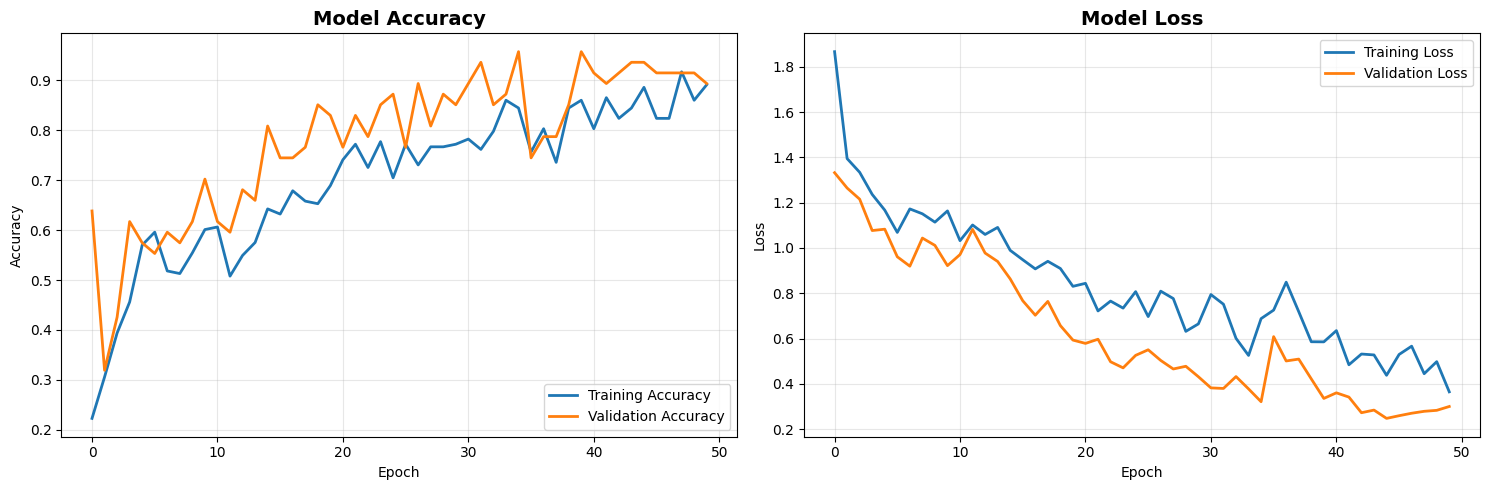


Best Epoch: 35
Best Validation Accuracy: 0.9574
Corresponding Training Accuracy: 0.8446


In [11]:
# Plot training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss curves
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")

## 9. Evaluate Model on Test Set

In [12]:
# Evaluate on test set
# First check if test generator has samples
if test_generator.samples == 0:
    print("Warning: Test set is empty! Creating test generator again...")
    # Recreate test generator without shuffle to ensure proper loading
    test_generator = test_generator.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print(f"Test samples loaded: {test_generator.samples}")

if test_generator.samples > 0:
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    print(f"\n{'='*50}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"{'='*50}")
    
    # Check if target accuracy is reached
    if test_accuracy >= 0.92:
        print(f"Congratulations! Target accuracy of 92% achieved!")
    else:
        print(f"Current accuracy {test_accuracy*100:.2f}% below 92% target, further optimization needed")
else:
    print("\n" + "="*50)
    print("ERROR: No test images found!")
    print(f"Please check the test directory: {test_dir}")
    print("Expected structure: test_dir/class_name/images.jpg")
    print("="*50)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step - accuracy: 0.9167 - loss: 0.3312

Test Accuracy: 91.67%
Test Loss: 0.3312
Current accuracy 91.67% below 92% target, further optimization needed


## 10. Generate Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


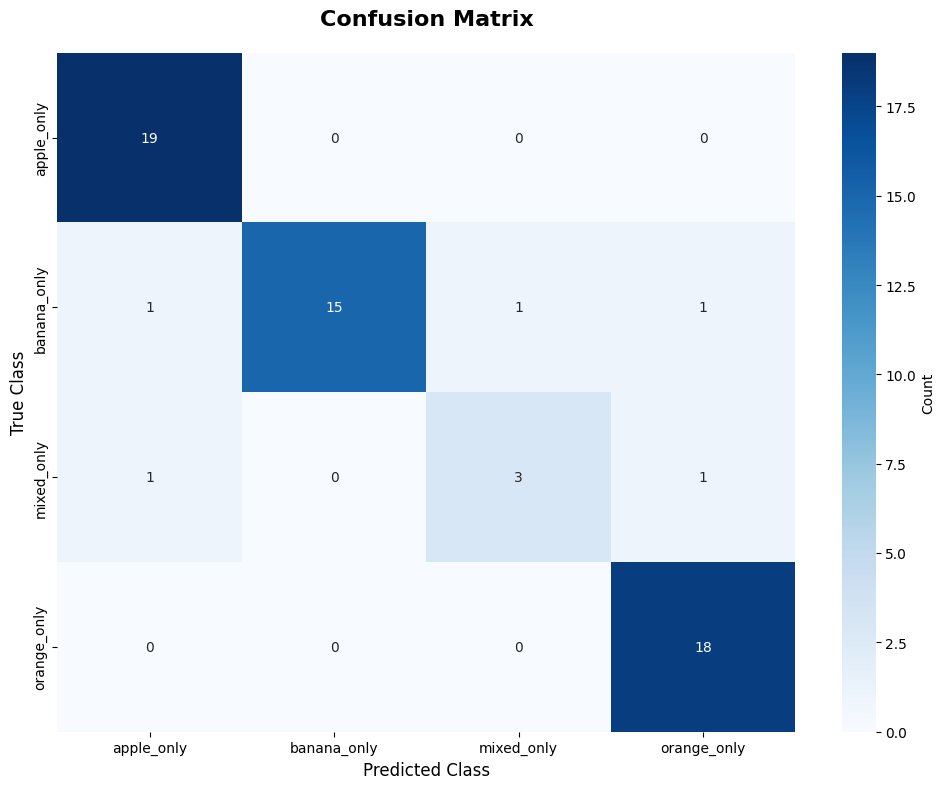


Classification Report:
              precision    recall  f1-score   support

  apple_only     0.9048    1.0000    0.9500        19
 banana_only     1.0000    0.8333    0.9091        18
  mixed_only     0.7500    0.6000    0.6667         5
 orange_only     0.9000    1.0000    0.9474        18

    accuracy                         0.9167        60
   macro avg     0.8887    0.8583    0.8683        60
weighted avg     0.9190    0.9167    0.9133        60



In [13]:
# Get predictions
from sklearn.metrics import confusion_matrix, classification_report

# Check if test set has samples before predicting
if test_generator.samples == 0:
    print("Cannot generate predictions: Test set is empty!")
    print("Please add test images to the test directory first.")
else:
    # Reset test generator
    test_generator.reset()
    
    # Predict
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # True labels
    y_true = test_generator.classes
    
    # Class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))

## 11. Visualize Prediction Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


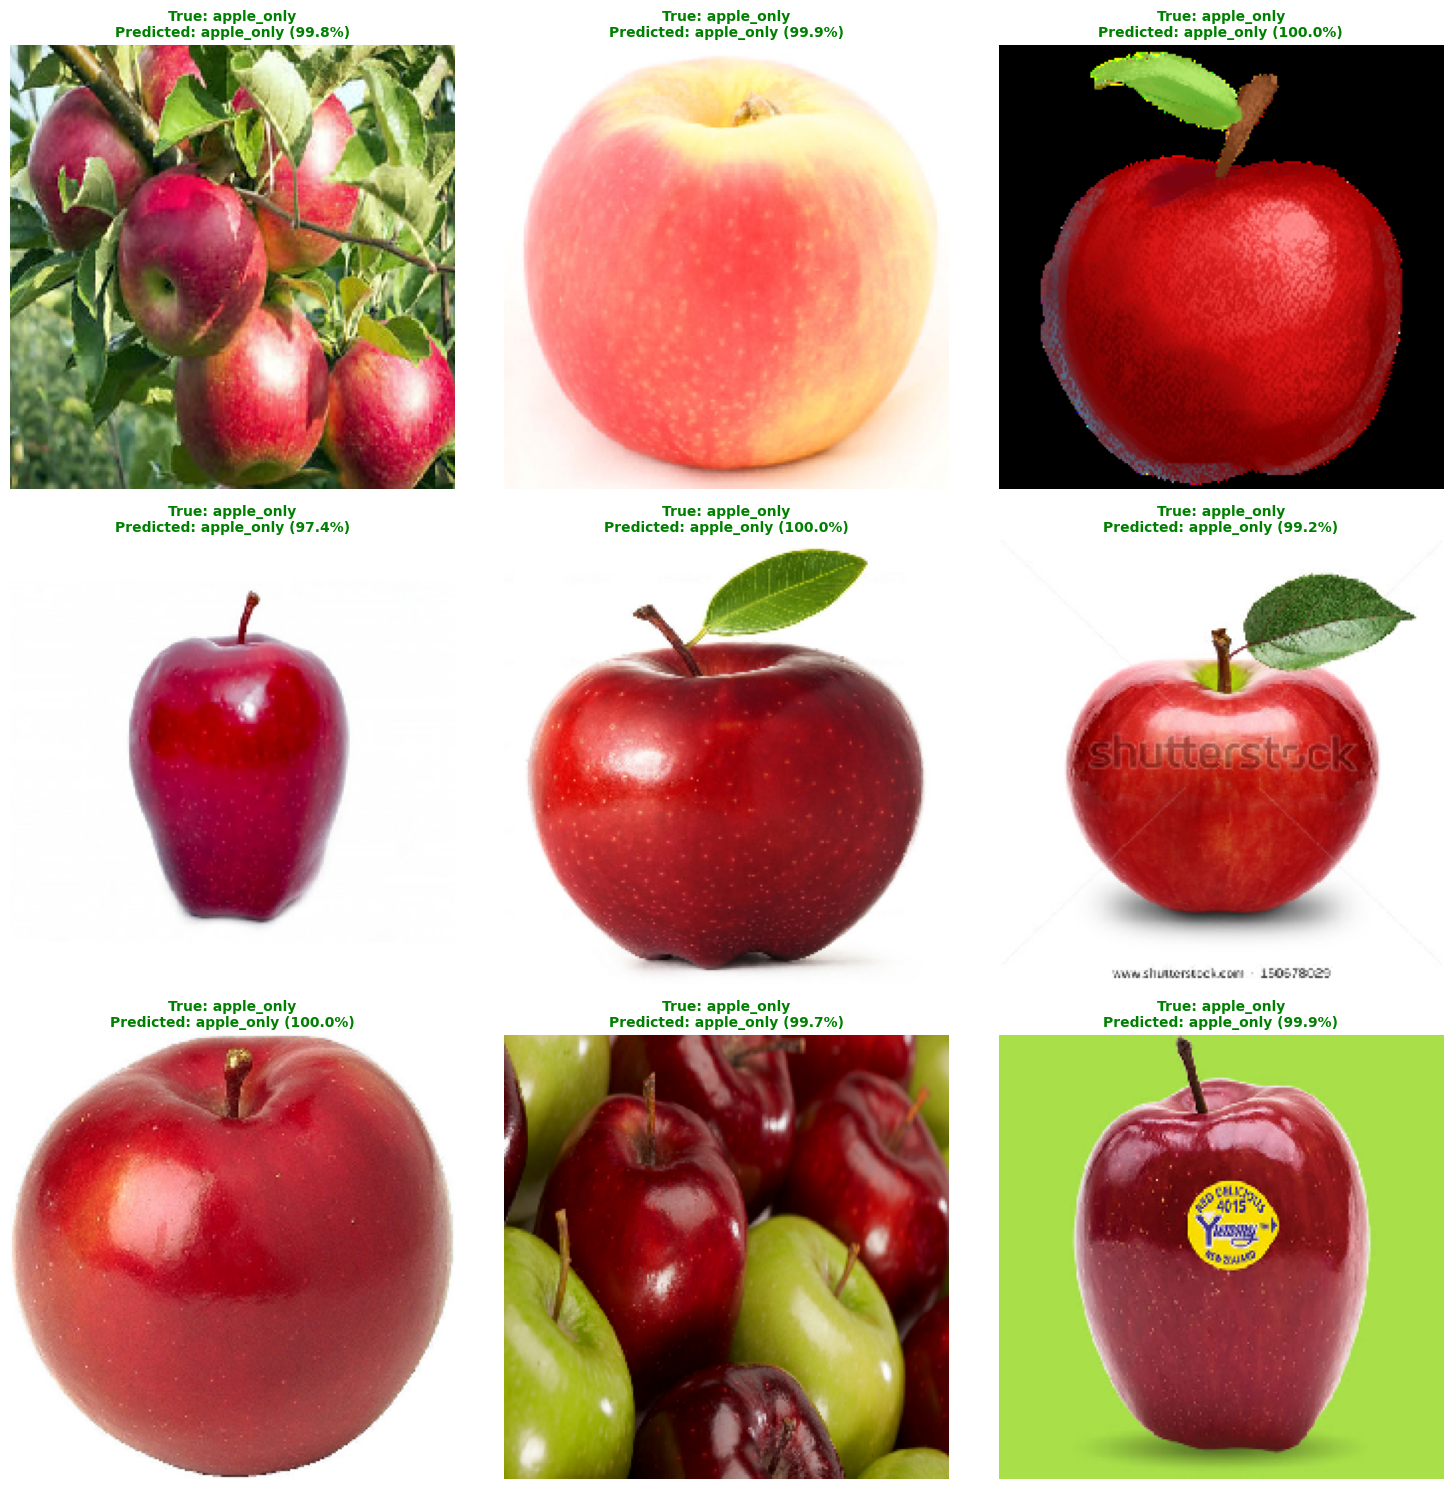

In [14]:
# Display prediction samples
from tensorflow.keras.preprocessing import image

def show_predictions(num_images=9):
    """Display prediction results"""
    if test_generator.samples == 0:
        print("Cannot show predictions: Test set is empty!")
        return
    
    # Reset test generator
    test_generator.reset()
    
    # Get a batch of images
    images, labels = next(test_generator)
    predictions = model.predict(images[:num_images])
    
    # Plot
    num_to_show = min(num_images, len(images))
    rows = int(np.ceil(num_to_show / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()
    
    for i in range(num_to_show):
        axes[i].imshow(images[i])
        
        true_label = class_labels[np.argmax(labels[i])]
        pred_label = class_labels[np.argmax(predictions[i])]
        pred_prob = np.max(predictions[i]) * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label} ({pred_prob:.1f}%)',
                         color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(9)

## 12. Save Model

In [15]:
# Save model in native Keras format (recommended)
model.save('fruit_classifier_cnn.keras')
print("Model saved as 'fruit_classifier_cnn.keras' (Native Keras format)")

# Also save in HDF5 format for compatibility
model.save('fruit_classifier_cnn.h5')
print("Model saved as 'fruit_classifier_cnn.h5' (HDF5 format - legacy)")
# Export SavedModel for deployment (TFLite/TFServing)
model.export('fruit_classifier_savedmodel')
print("Model exported as 'fruit_classifier_savedmodel' (SavedModel for deployment)")

print("\n" + "=" * 60)
print("Model Saving Summary:")
print("  • fruit_classifier_cnn.keras     - Native Keras (recommended)")
print("  • fruit_classifier_cnn.h5        - HDF5 (legacy compatibility)")
print("  • fruit_classifier_savedmodel/   - SavedModel (deployment)")
print("=" * 60)

Model saved as 'fruit_classifier_cnn.keras' (Native Keras format)
Model saved as 'fruit_classifier_cnn.h5' (HDF5 format - legacy)
INFO:tensorflow:Assets written to: fruit_classifier_savedmodel/assets


INFO:tensorflow:Assets written to: fruit_classifier_savedmodel/assets


Saved artifact at 'fruit_classifier_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139654596514512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654596519440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580542400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580540464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580549616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580550320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580674528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580675232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580679984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654580944960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139

### Added new code to put in conditions for saving models to prevent bloat [YC]

In [ ]:
import os

# --- 1. Define your filename ---
# Use a specific name so you don't confuse it with other experiments
model_filename = 'fruit_classifier_cnn_v1.h5'

# --- 2. Save the model ---
print(f"Saving model to {model_filename}...")
model.save(model_filename)

# --- 3. Safety Check: File Size ---
# Get size in bytes and convert to Megabytes (MB)
file_size_bytes = os.path.getsize(model_filename)
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"\n--- GITHUB SAFETY CHECK ---")
print(f"File Size: {file_size_mb:.2f} MB")

if file_size_mb < 50:
    print("✅ SAFE: You can upload this model to GitHub.")
    print("   Run: git add -f " + model_filename)
elif file_size_mb < 100:
    print("⚠️ WARNING: This file is large (over 50MB). GitHub might warn you.")
    print("   You can still upload it, but try to reduce size if possible.")
else:
    print("❌ STOP: This file is too big (>100MB)!")
    print("   Do NOT try to push this to GitHub. It will be rejected.")
    print("   Action: Upload to Google Drive and share the link instead.")